In [1]:
% load_ext autoreload
% autoreload 2

In [2]:
import lightkurve as lk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from patsy import dmatrix
from lightkurve.correctors import DesignMatrix, DesignMatrixCollection

In [213]:
#tpf = lk.search_targetpixelfile('K2-43').download()
lcf = lk.search_lightcurvefile('K2-43').download()

In [214]:
def get_spline_dm(x, n_knots=20, degree=3, name='spline', include_intercept=False):
    spline_dm = np.asarray(dmatrix("bs(x, df={}, degree={}, include_intercept={}) - 1".format(n_knots, degree, include_intercept), {"x": x}))
    df = pd.DataFrame(spline_dm, columns=['knot{}'.format(idx + 1) for idx in range(n_knots)])
    return DesignMatrix(df, name=name)

def get_centroid_dm(c, r, name='centroids'):
    arclength = ((c - c.min())**2 + (r - r.min())**2)**0.5

    ar = [c, r,
          c**2, r**2,
          c**3, r**3,
          c*r,
          c**2*r, c*r**2, c**2*r**2]

    columns = [r'col', r'row',
               r'col^2', r'row^2',
               r'col^3', r'row^3',
               r'col \times row', r'col^2 \times row', r'col \times row^2', r'col^2 \times row^2']

    df = pd.DataFrame(np.asarray(ar).T, columns=columns)
    return DesignMatrix(df, name=name)

def get_pixel_dm(pixels):
    pass

In [215]:
from astropy.modeling import models, fitting
def _get_window_points(self, windows, arc, breakindex):
        ''' Build window points, based on where thrusters are fired. '''

        def _get_thruster_firings(arclength):
            ''' Find locations where K2 fired thrusters
            Parameters:
            ----------
            arc : np.ndarray
                arclength as a function of time
            Returns:
            -------
            thrusters: np.ndarray of bools
                True at times where thrusters were fired.
            '''
            arc = np.copy(arclength)
            # Rate of change of rate of change of arclength wrt time
            d2adt2 = (np.gradient(np.gradient(arc)))
            # Fit a nice Gaussian, most points lie in a tight region, thruster firings are outliers
            g = models.Gaussian1D(amplitude=100, mean=0, stddev=0.01)
            fitter = fitting.LevMarLSQFitter()
            h = np.histogram(d2adt2[np.isfinite(d2adt2)], np.arange(-0.5, 0.5, 0.0001), density=True);
            xbins = h[1][1:] - np.median(np.diff(h[1]))
            g = fitter(g, xbins, h[0], weights=h[0]**0.5)

            def _start_and_end(method):
                ''' Find points at the start or end of a roll
                '''
                if method == 'start':
                    thrusters = (d2adt2 < (g.stddev * -5)) & np.isfinite(d2adt2)
                if method == 'end':
                    thrusters = (d2adt2 > (g.stddev * 5)) & np.isfinite(d2adt2)
                # Pick the best thruster in each cluster
                idx = np.array_split(np.arange(len(thrusters)), np.where(np.gradient(np.asarray(thrusters, int)) == 0)[0])
                m = np.array_split(thrusters, np.where(np.gradient(np.asarray(thrusters, int)) == 0)[0])
                th = []
                for jdx in range(len(idx)):
                    if m[jdx].sum() == 0:
                        th.append(m[jdx])
                    else:
                        th.append((np.abs(np.gradient(arc)[idx[jdx]]) == np.abs(np.gradient(arc)[idx[jdx]][m[jdx]]).max()) & m[jdx])
                thrusters = np.hstack(th)
                return thrusters

            # Get the start and end points
            thrusters = np.asarray([_start_and_end('start'), _start_and_end('end')])
            thrusters = thrusters.any(axis=0)

            # Take just the first point.
            thrusters = (np.gradient(np.asarray(thrusters, int)) >= 0) & thrusters
            return thrusters

        thrusters = _get_thruster_firings(arc)
        thrusters[breakindex] = True
        thrusters = np.where(thrusters)[0]

        if breakindex != 0:
            window_points = np.append(np.linspace(0, breakindex + 1, windows//2 + 1, dtype=int)[1:],
                                  np.linspace(breakindex + 1, len(arc), windows//2 + 1, dtype=int)[1:-1])
            window_points[np.argmin((window_points - breakindex + 1)**2)] = breakindex + 1
        else:
            window_points = np.linspace(0, len(self.flux) + 1, windows)
        window_points = [thrusters[np.argmin(np.abs(wp - thrusters))] + 1 for wp in window_points]

        if window_points[0] < (np.median(np.diff(window_points)) * 0.4):
            window_points = window_points[1:]
        return window_points


In [216]:
lc = lcf.PDCSAP_FLUX.remove_nans()

In [217]:
c, r = lc.centroid_col - lc.centroid_col.mean(), lc.centroid_row  - lc.centroid_row.mean()
arclength = ((c - c.min())**2 + (r - r.min())**2)**0.5
dm = lk.correctors.DesignMatrixCollection([get_centroid_dm(c, r).append_constant().split(1753), get_spline_dm(lc.time, n_knots=80)])

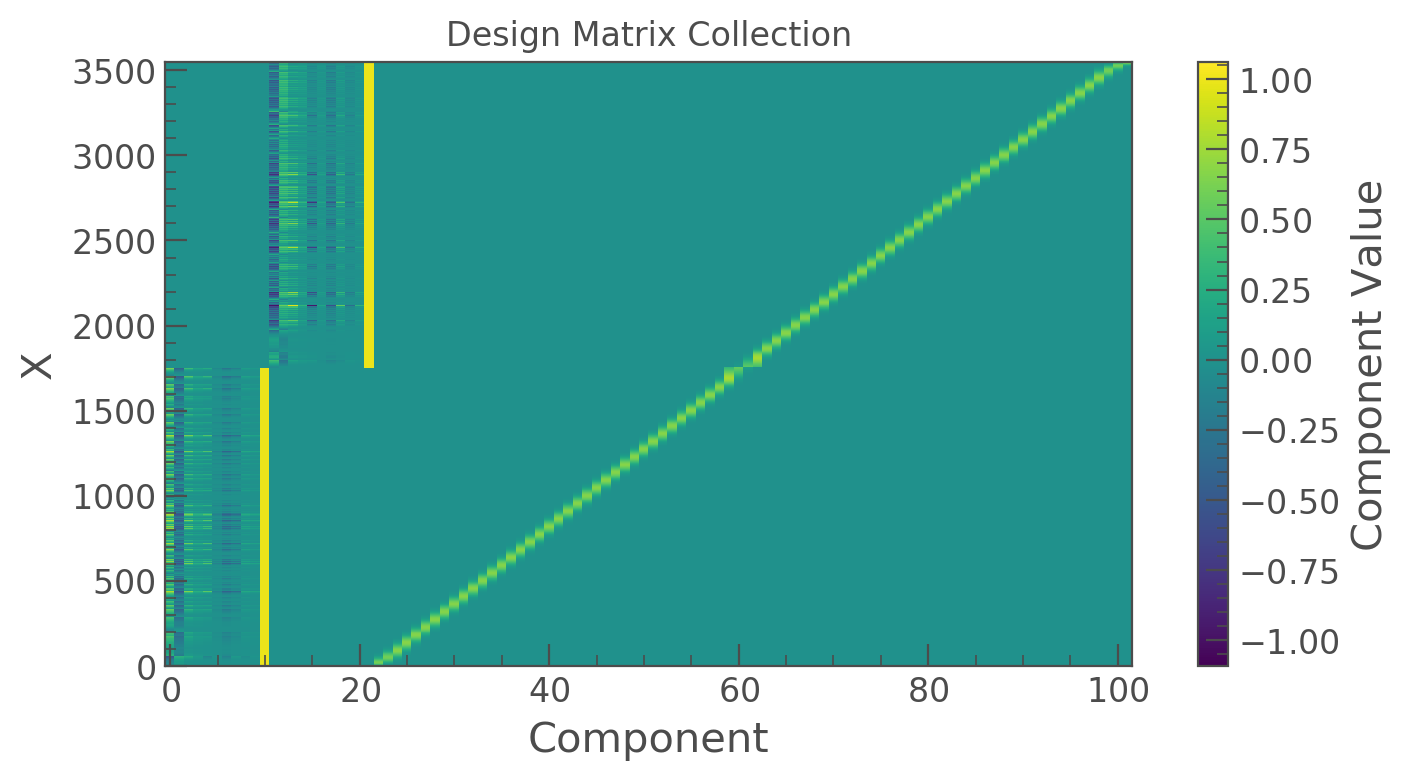

In [218]:
dm.plot()

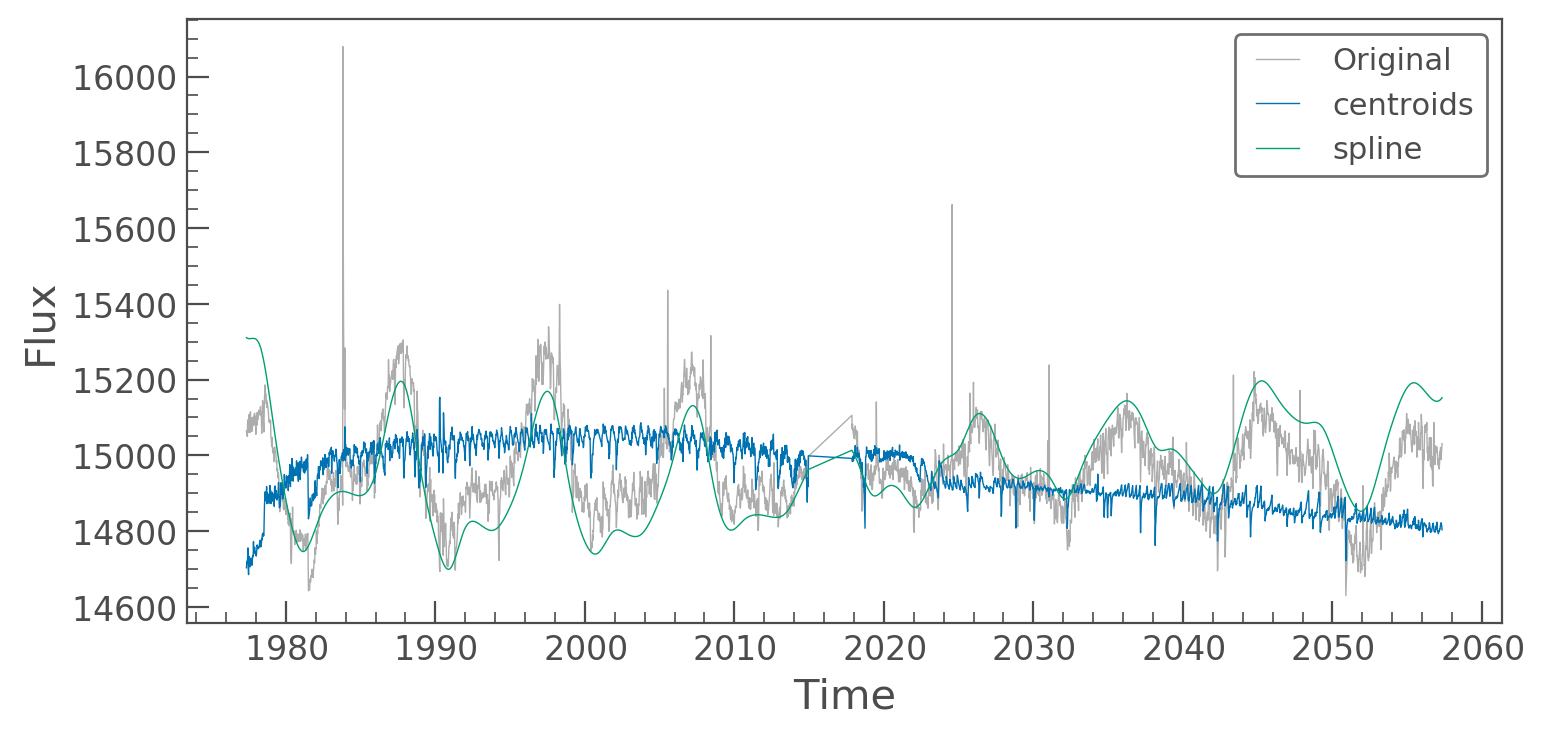

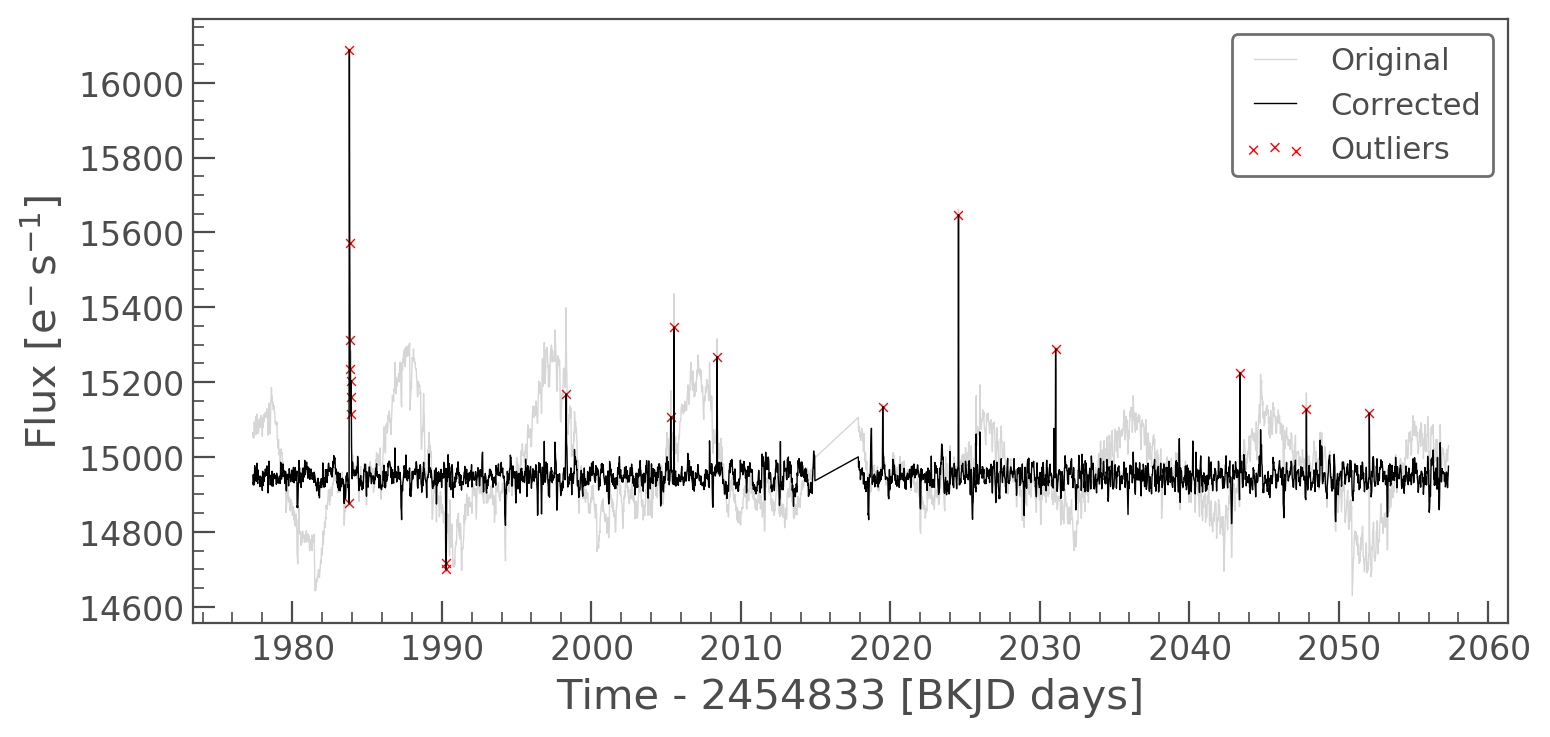

In [219]:
r = lk.correctors.RegressionCorrector(lc, dm)
r.correct(niters=5)
r.diagnose()

In [220]:
# def get_sff_dm(lc, breakindex=1753, windows=5, bins=5, n_knots=80):
#     c, r = lc.centroid_col - lc.centroid_col.mean(), lc.centroid_row  - lc.centroid_row.mean()
#     arclength = ((c - c.min())**2 + (r - r.min())**2)**0.5

#     # centroids
#     c_dm = get_centroid_dm(c, r).split(1753).whiten()

#     # long term
#     lt_dm = get_spline_dm(lc.time, n_knots=n_knots, include_intercept=True)

#     # sff
#     window_points = _get_window_points(lc, windows, arclength, breakindex)
#     sff_dm = get_spline_dm(arclength, n_knots=bins, name='arclength', degree=3, include_intercept=True)
    
    
#     return DesignMatrixCollection([lt_dm, sff_dm.split(window_points)]), window_points

In [243]:
windows = 20
bins = 5
degree = 3
include_intercept=False
breakindex=1753
wp = _get_window_points(lc, windows, arclength, breakindex)


lower_idx = np.append(0, wp)
upper_idx = np.append(wp, len(lc.time))

stack = []
columns = []
for idx, a, b in zip(range(len(lower_idx)), lower_idx, upper_idx):
    #knots = list(np.linspace(*np.percentile(arclength[a:b], [5, 95]), bins))
    knots = list(np.percentile(arclength[a:b], np.linspace(0, 100, bins+1)[1:-1]))
    ar = np.copy(arclength)
    ar[~np.in1d(ar, ar[a:b])] = -1
    dm = np.asarray(dmatrix("bs(x, knots={}, degree={}, include_intercept={}) - 1".format(knots, degree, include_intercept), {"x": ar}))
    stack.append(dm)
    columns.append(['window{}_bin{}'.format(idx+1, jdx+1) for jdx in range(len(dm.T))])


sff_dm = DesignMatrix(pd.DataFrame(np.hstack(stack), columns=np.hstack(columns)), name='arclength')

# long term
s_dm = get_spline_dm(lc.time, n_knots=100, include_intercept=True)


#c_dm = DesignMatrix(pd.DataFrame(np.asarray([lc.centroid_col, lc.centroid_row]).T, columns=['col', 'row']), name='c')
c_dm = get_centroid_dm(lc.centroid_col, lc.centroid_row)
dm = DesignMatrixCollection([c_dm, s_dm.append_constant(), sff_dm])

In [244]:
r = lk.correctors.RegressionCorrector(lc, dm)
r.correct(niters=5)

KeplerLightCurve(ID: 201205469)

In [245]:
r.corrected_lc.estimate_cdpp()

476.85694283476755

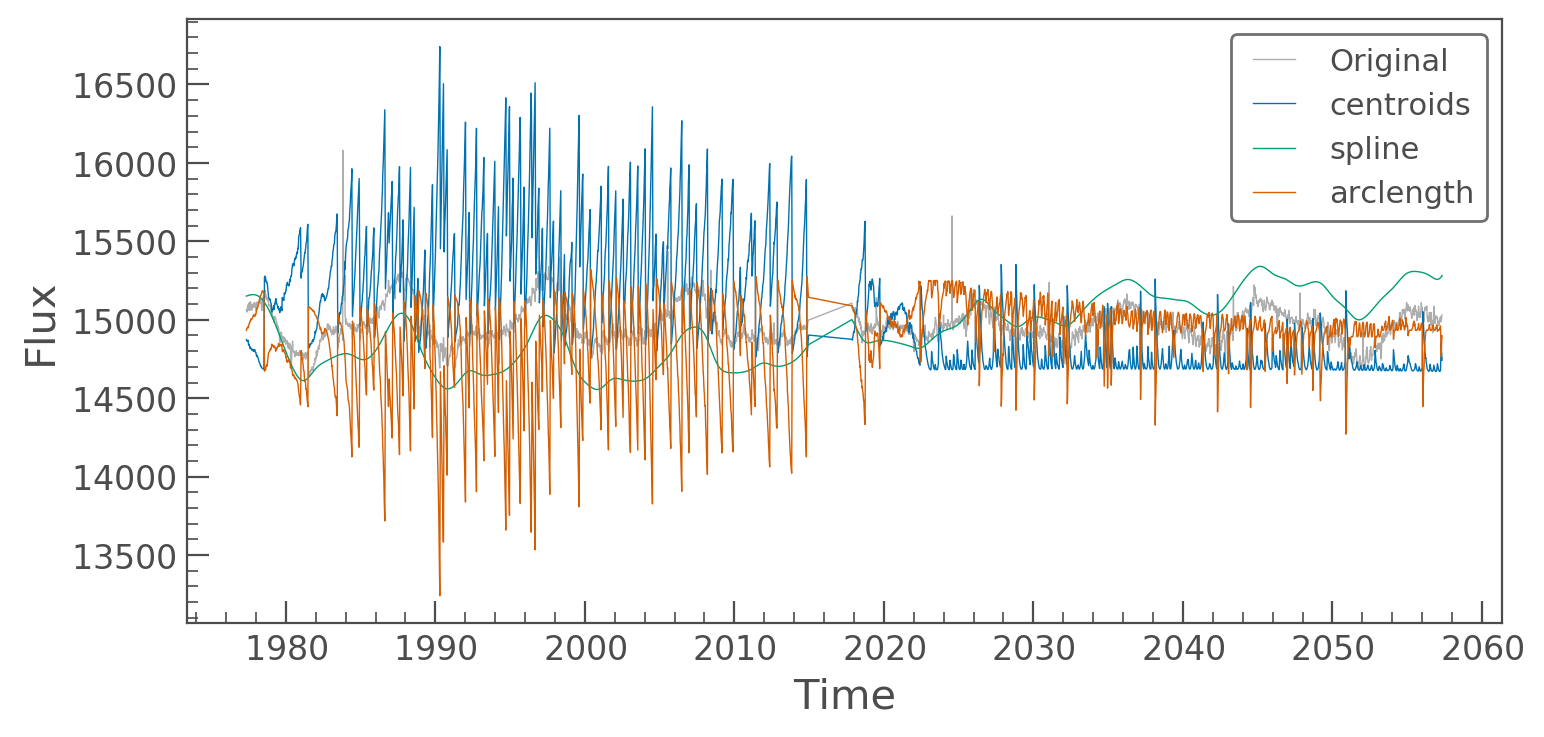

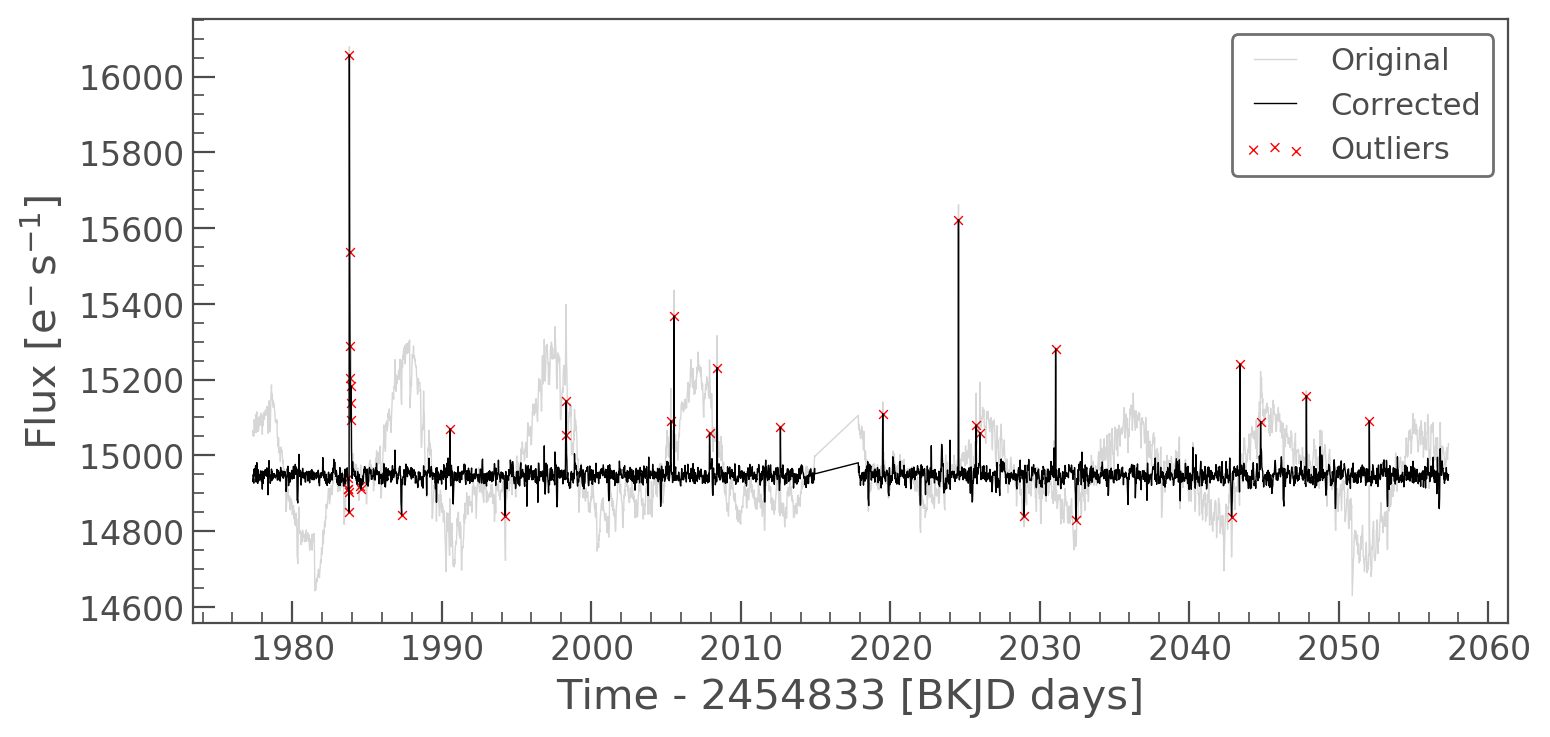

In [246]:
r.diagnose()

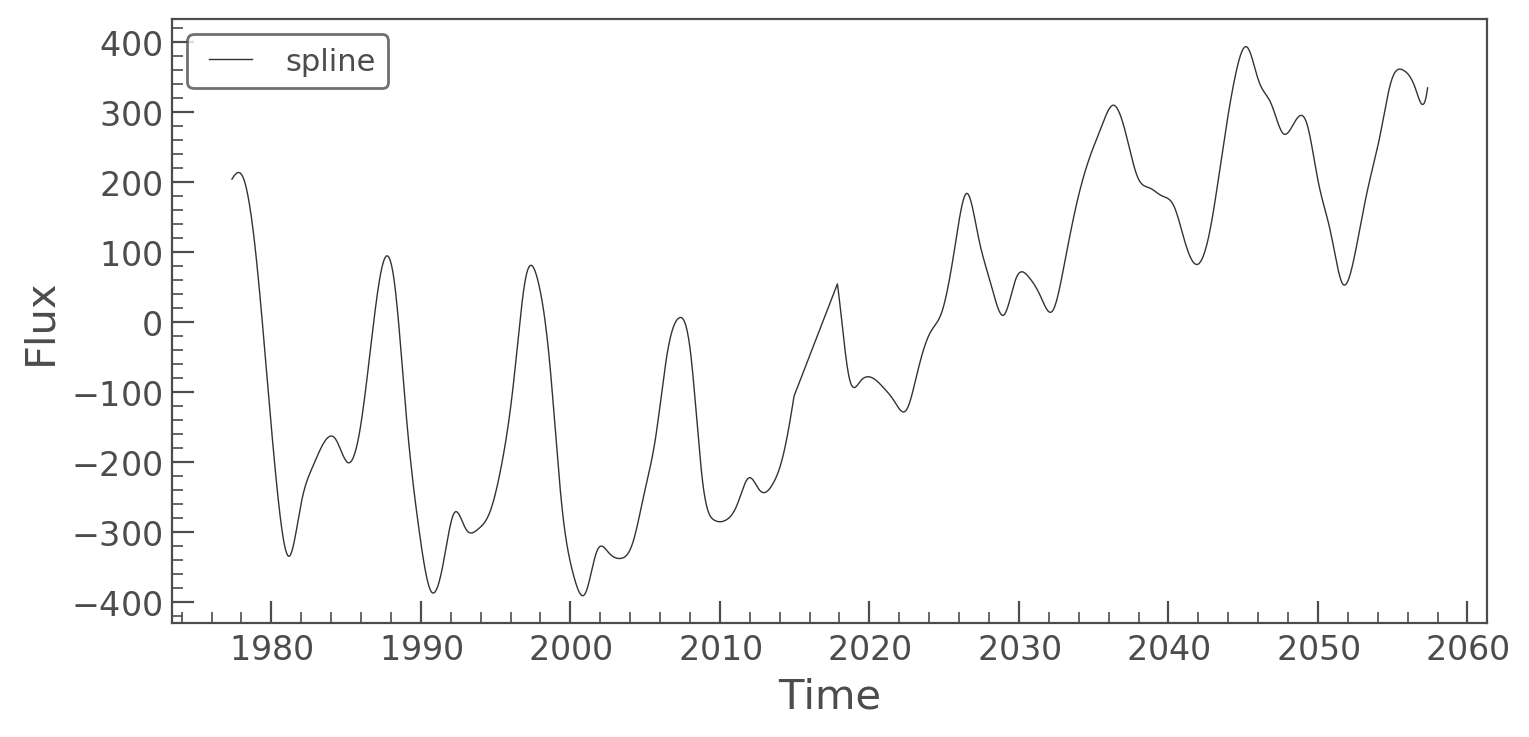

In [247]:
r.diagnostic_lightcurves['spline'].plot()

In [144]:
# lower_idx = np.append(0, wp)
# upper_idx = np.append(wp, len(lc.time))
# f = (lc.flux - r.diagnostic_lightcurves['spline'].flux)
# m = r.diagnostic_lightcurves['arclength'].flux

# for a, b in zip(lower_idx, upper_idx):
#     #plt.figure()
#     plt.scatter(arclength[a:b], f[a:b], s=1)
#     plt.scatter(arclength[a:b][~r.cadence_mask[a:b]], f[a:b][~r.cadence_mask[a:b]], s=10, marker='x')

#     s = np.argsort(arclength[a:b])
#     plt.plot(arclength[a:b][s], (m[a:b] - np.median(m[a:b]) + np.median(f[a:b]))[s])
#     plt.xlabel('Arclength')
#     plt.ylabel('Flux')
#     #break

In [145]:
# lower_idx = np.append(0, wp)
# upper_idx = np.append(wp, len(lc.time))
# f = (lc.flux - r.diagnostic_lightcurves['spline'].flux)
# m = r.diagnostic_lightcurves['arclength'].flux

# for a, b in zip(lower_idx, upper_idx):
#     plt.figure()
#     plt.scatter(arclength[a:b], f[a:b], c='k', s=1)
#     plt.scatter(arclength[a:b][~r.cadence_mask[a:b]], f[a:b][~r.cadence_mask[a:b]], c='r', s=10, marker='x')

#     s = np.argsort(arclength[a:b])
#     plt.plot(arclength[a:b][s], (m[a:b] - np.median(m[a:b]) + np.median(f[a:b]))[s], c='b')
#     plt.xlabel('Arclength')
#     plt.ylabel('Flux')
#     #break

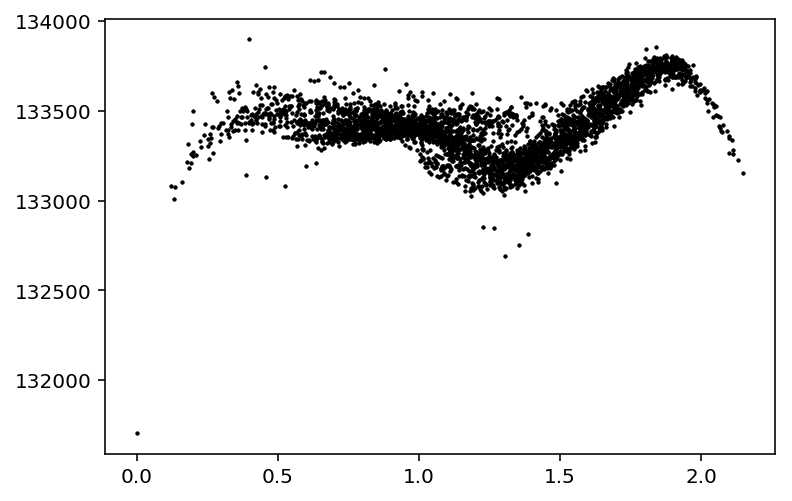

In [133]:
plt.scatter(arclength, lc.flux - r.diagnostic_lightcurves['spline'].flux, s=1, c='k')
plt.scatter(arclength, lc.flux - r.diagnostic_lightcurves['spline'].flux, s=1, c='k')

In [ ]:
r.X.plot()

In [ ]:
np.hstack([d.columns for d in dm])